In [36]:
from pyomo.environ import *
import pyomo.environ as pyo
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from IPython.display import clear_output
import time
import copy
from scipy.spatial import Voronoi, voronoi_plot_2d
import gurobipy as gp
from gurobipy import GRB

In [37]:
geodata = pd.read_csv('CommunityClubsTest-clean.csv')
print(geodata)
bloodbankcoords = pd.read_csv('HSA bloodbank coordinates1.csv')
print(bloodbankcoords)

            Y           X     Name
0    1.427493  103.792241    kml_1
1    1.354658  103.889546    kml_2
2    1.397128  103.886666    kml_3
3    1.366833  103.840668    kml_4
4    1.320799  103.747540    kml_5
..        ...         ...      ...
120  1.339973  103.737066  kml_121
121  1.386807  103.771521  kml_122
122  1.341263  103.933010  kml_123
123  1.311728  103.952223  kml_124
124  1.339360  103.727300  kml_125

[125 rows x 3 columns]
       Blood Bank  Postal Code  Latitude   Longitude
0             HSA       169078  1.281335  103.838482
1     Dhoby Ghaut       238826  1.299755  103.846084
2  Westgate Tower       608531  1.335374  103.743005
3       Woodlands       730900  1.436139  103.787195
4     One Punggol       828629  1.408468  103.905039


In [38]:
# y-coordinates/latitude of CCs and BBs
y_coordCC = geodata['Y']
y_coordBB = bloodbankcoords['Latitude']

# x-coordinates/longitude of CCs and BBs
x_coordCC = geodata['X']
x_coordBB = bloodbankcoords['Longitude']

#no. of BBs
nbrblood = 5

#no. of CCs
nbrcomm = 125

#radius of earth
R = 6371


def deg_to_rad(degrees):
    return degrees*(np.pi/180)

# distance calculations between CC and BBs
distancelct=np.empty([nbrblood, nbrcomm])
for i_index in range(nbrblood):
    for j_index in range(nbrcomm):
        d_lon = deg_to_rad(x_coordBB[i_index]-x_coordCC[j_index])
        d_lat = deg_to_rad(y_coordBB[i_index]-y_coordCC[j_index])
        a = np.sin(d_lat/2)**2 +np.cos(deg_to_rad(x_coordBB[i_index])) * np.cos(deg_to_rad(x_coordCC[j_index])) * np.sin(d_lon/2)**2
        c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
        distancelct[i_index,j_index] = R*c

print(distancelct)

[[1.62983199e+01 8.26590280e+00 1.29394220e+01 9.50717786e+00
  5.00689545e+00 5.43578204e+00 6.44300145e+00 7.58764858e+00
  8.17363056e+00 7.86046128e+00 1.14428299e+01 8.02723195e+00
  7.81813030e+00 7.43194037e-01 1.07288287e+01 6.81401263e+00
  3.33524796e+00 3.23571747e+00 1.82106360e+01 7.72756572e+00
  1.00614038e+01 1.66251696e+01 1.13344084e+01 1.04985128e+01
  4.56619666e+00 2.77526169e+00 6.05100040e+00 6.10142290e+00
  6.08268778e+00 1.23176604e+01 1.65649038e+01 1.69527481e+00
  1.18569748e+01 1.97601464e+01 8.35295503e+00 4.20059615e+00
  3.92546738e+00 6.57862029e-01 9.17948424e+00 8.95899829e+00
  9.38767232e+00 1.03026548e+01 5.94717451e-01 3.02966682e+00
  3.39166177e+00 8.25992473e+00 8.10243742e+00 6.24912164e+00
  4.10461572e+00 5.65181442e+00 2.47816418e+00 5.05381684e+00
  4.38605478e+00 2.47060238e+00 1.16891904e+01 1.01935457e+01
  9.50964057e-01 4.83327174e+00 1.21567791e-01 1.13629607e+00
  1.28719975e+01 4.85001883e+00 3.22717498e+00 1.77991958e+01
  8.9851

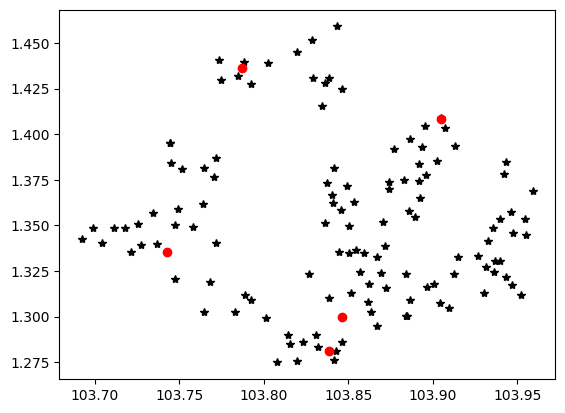

In [39]:
# 'coordlct_x' and 'coordlct_y' represent the coordinates of the facilities.
plt.plot(x_coordCC, y_coordCC, '*', color='black');
plt.plot(x_coordBB, y_coordBB, 'o', color='red');

In [40]:
# Initialize empty solutions to populate from each iteration of epsilon-constraint method 
optimal_costs = []
optimal_distances = []
detailed_solutions = []


 #Create Model
model = gp.Model("P_Median_Epsilon_Constraint_Style")

I = list(range(nbrblood)) #Open Facilities
J = list(range(nbrcomm)) #Facilities to be served

 # Define variables:
x = model.addVars(I, J, vtype=GRB.BINARY, name="assign")  # If demand from location i is served by open facility j then x_ij=1 otherwise x_ij=0
y = model.addVars(I, vtype=GRB.BINARY, name="open") # Facility i to open. y_i=0 if closed and y_i=1 if open

 # Define objective functions
model.setObjective(gp.quicksum(x[i, j] * distancelct[i][j] for i in I for j in J), GRB.MINIMIZE) # Minimize total distance from demands to the nearest open facilities
 # Each demand location j must be assigned to exactly one facility i
model.addConstrs((gp.quicksum(x[i, j] for i in I) == 1 for j in J), name="assign_once")
 # The demand from location i can only be assigned to an open facility j
model.addConstrs((x[i, j] <= y[i] for i in I for j in J), name="only_open")
model.addConstr(gp.quicksum(y[i] for i in I) == nbrblood, name="open_facilities")

q_c = [random.randint(1, 5) for _ in range(nbrcomm)]    # Example: blood collected at each clinic
g_b = [50, 60, 70, 65, 55]                 # Min blood required at each bank
q_b = [100, 120, 130, 110, 115]            # Max capacity at each bank

model.addConstr(gp.quicksum(q_c[i] * x[i, j] for i in I for j in J) >= 400, name="lower_bound_sum")

model.addConstr(gp.quicksum(q_c[i] * x[i, j] for i in I for j in J) <= 400*1.6, name="upper_bound_sum")

model.addConstrs((gp.quicksum(x[i, j] for j in J) <= q_b[i] * y[i] for i in I), name="capacity_constraints")  # Capacity constraints for each bank


f_bc = 0.094*2.61
model.addConstr(gp.quicksum(f_bc*distancelct[i][j] * x[i, j] for i in I for j in J) <= 1000, name="budget_constraint")

model.optimize()

# Check if a solution was found
if model.status == gp.GRB.OPTIMAL:
    print(f"Optimal objective value: {model.objVal}")

    # Print values of decision variables
    for var in model.getVars():
        if var.X > 1e-6:  # print only non-zero values
            print(f"{var.VarName} = {var.X}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 759 rows, 630 columns and 4385 nonzeros
Model fingerprint: 0x9c8d89a8
Variable types: 0 continuous, 630 integer (630 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+02]
  Objective range  [2e-02, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 939.5444576
Presolve removed 719 rows and 467 columns
Presolve time: 0.00s
Presolved: 40 rows, 163 columns, 276 nonzeros
Found heuristic solution: objective 593.9319143
Variable types: 0 continuous, 163 integer (162 binary)
Found heuristic solution: objective 452.1832717

Root relaxation: objective 3.196504e+02, 0 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds   

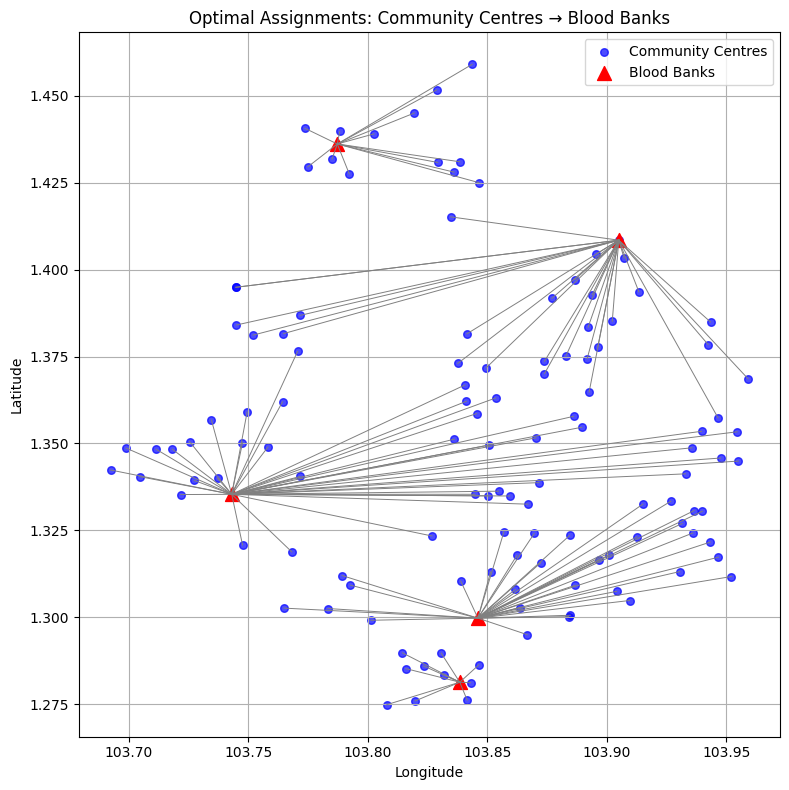

In [41]:

# Assume you have:
# df_comm: DataFrame with columns ['Y','X','Name'] for community centres
# df_bank: DataFrame with ['Latitude','Longitude','Blood Bank'] for blood banks

# Extract coordinates
comm_coords = geodata[['X','Y']].values
bank_coords = bloodbankcoords[['Longitude','Latitude']].values

# Plot nodes
plt.figure(figsize=(8, 8))
plt.scatter(comm_coords[:,0], comm_coords[:,1], c='blue', label='Community Centres', s=30, alpha=0.7)
plt.scatter(bank_coords[:,0], bank_coords[:,1], c='red', label='Blood Banks', s=100, marker='^')

# Draw assignment lines
for i in I:
    for j in J:
        if x[i, j].X > 0.5:
            bx, by = bank_coords[i]
            cx, cy = comm_coords[j]
            plt.plot([bx, cx], [by, cy], c='gray', linewidth=0.7)

plt.title("Optimal Assignments: Community Centres → Blood Banks")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
